In [31]:
import paddle
import paddle.fluid as fluid
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt

## Build model

### vgg

In [2]:
def vgg_bn_drop(input):  # define the method of convolution and pooling
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt,
            pool_size=2,
            pool_stride=2,  # step of pooling
            conv_num_filter=[num_filter] * groups,  # num of conv kernels
            conv_filter_size=3,
            conv_act='relu',
            conv_with_batchnorm=True,  # normalization
            conv_batchnorm_drop_rate=dropouts,  # prevent Overfitting
            pool_type='max') # method of pooling: choose max value

    conv1 = conv_block(input, 64, 2, [0.3, 0])
    conv2 = conv_block(conv1, 128, 2, [0.4, 0])
    conv3 = conv_block(conv2, 256, 3, [0.4, 0.4, 0])
    conv4 = conv_block(conv3, 512, 3, [0.4, 0.4, 0])
    conv5 = conv_block(conv4, 512, 3, [0.4, 0.4, 0])

    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.5)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=10, act='softmax')
    return predict

### resnet

In [3]:
def conv_bn_layer(input,
                  ch_out,
                  filter_size,
                  stride,
                  padding,
                  act='relu',
                  bias_attr=False):
    tmp = fluid.layers.conv2d(
        input=input,
        filter_size=filter_size,
        num_filters=ch_out,
        stride=stride,
        padding=padding,
        act=None,
        bias_attr=bias_attr)
    return fluid.layers.batch_norm(input=tmp, act=act)

def shortcut(input, ch_in, ch_out, stride):
    if ch_in != ch_out:
        return conv_bn_layer(input, ch_out, 1, stride, 0, None)
    else:
        return input

def basicblock(input, ch_in, ch_out, stride):
    tmp = conv_bn_layer(input, ch_out, 3, stride, 1)
    tmp = conv_bn_layer(tmp, ch_out, 3, 1, 1, act=None, bias_attr=True)
    short = shortcut(input, ch_in, ch_out, stride)
    return fluid.layers.elementwise_add(x=tmp, y=short, act='relu')

def layer_warp(block_func, input, ch_in, ch_out, count, stride):
    tmp = block_func(input, ch_in, ch_out, stride)
    for i in range(1, count):
        tmp = block_func(tmp, ch_out, ch_out, 1)
    return tmp
def resnet_cifar10(ipt, depth=32):
    # depth should be one of 20, 32, 44, 56, 110, 1202
    assert (depth - 2) % 6 == 0
    n = (depth - 2) // 6
    nStages = {16, 64, 128}
    conv1 = conv_bn_layer(ipt, ch_out=16, filter_size=3, stride=1, padding=1)
    res1 = layer_warp(basicblock, conv1, 16, 16, n, 1)
    res2 = layer_warp(basicblock, res1, 16, 32, n, 2)
    res3 = layer_warp(basicblock, res2, 32, 64, n, 2)
    pool = fluid.layers.pool2d(
        input=res3, pool_size=8, pool_type='avg', pool_stride=1)
    predict = fluid.layers.fc(input=pool, size=10, act='softmax')
    return predict

## train_program

In [4]:
def inference_program():
    # The image is 32 * 32 with RGB representation.
    data_shape = [None, 3, 32, 32] # 3D, colorul image
    images = fluid.data(name='pixel', shape=data_shape, dtype='float32')

#     predict = resnet_cifar10(images, 32)
    predict = vgg_bn_drop(images) # Use VGG16 (convolution) to predict
    return predict

In [5]:
def train_program():
    predict = inference_program()

    label = fluid.data(name='label', shape=[None,1], dtype='int64')
    cost = fluid.layers.cross_entropy(input=predict, label=label)  # cross entropy
    avg_cost = fluid.layers.mean(cost)  # mean cross entropy
    accuracy = fluid.layers.accuracy(input=predict, label=label)
    return [avg_cost, accuracy, predict]

## Optimizer

In [6]:
def optimizer_program():
    return fluid.optimizer.Adam(learning_rate=0.001)

## Data

In [7]:
# Each batch will yield 128 images
BATCH_SIZE = 128

# Reader for training
train_reader = paddle.batch(paddle.reader.shuffle(paddle.dataset.cifar.train10(),
                                                  buf_size=50000),
                            batch_size=BATCH_SIZE
                            )

# Reader for testing. A separated data set for testing.
test_reader = paddle.batch(paddle.dataset.cifar.test10(), batch_size=BATCH_SIZE)

Cache file C:\Users\Xin/.cache/paddle/dataset\cifar\cifar-10-python.tar.gz not found, downloading https://dataset.bj.bcebos.com/cifar/cifar-10-python.tar.gz 
Begin to download

Download finished


## Executor

In [8]:
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

feed_order = ['pixel', 'label']

main_program = fluid.default_main_program()
star_program = fluid.default_startup_program()

avg_cost, acc, predict = train_program()

# Test program
test_program = main_program.clone(for_test=True)

optimizer = optimizer_program()
optimizer.minimize(avg_cost)

exe = fluid.Executor(place)

EPOCH_NUM = 2

# For training test cost
def train_test(program, reader):
    count = 0
    feed_var_list = [program.global_block().var(var_name) for var_name in feed_order]
    feeder_test = fluid.DataFeeder(feed_list=feed_var_list, place=place)
    test_exe = fluid.Executor(place)
    accumulated = len([avg_cost, acc]) * [0]
    for tid, test_data in enumerate(reader()):
        avg_cost_np = test_exe.run(program=program,
                                   feed=feeder_test.feed(test_data),
                                   fetch_list=[avg_cost, acc]
                                   )
        accumulated = [x[0] + x[1][0] for x in zip(accumulated, avg_cost_np)]
        count += 1
    return [x / count for x in accumulated]

## Parameters

In [9]:
params_dirname = "image_classification_resnet.inference.model"

from paddle.utils.plot import Ploter

train_prompt = "Train cost"
test_prompt = "Test cost"
plot_cost = Ploter(test_prompt,train_prompt)

## Train loop

In [10]:
# main train loop.
def train_loop():
    feed_var_list_loop = [
        main_program.global_block().var(var_name) for var_name in feed_order
    ]
    feeder = fluid.DataFeeder(
        feed_list=feed_var_list_loop, place=place)
    exe.run(star_program)

    step = 0
    for pass_id in range(EPOCH_NUM):
        for step_id, data_train in enumerate(train_reader()):
            avg_loss_value = exe.run(main_program,
                                     feed=feeder.feed(data_train),
                                     fetch_list=[avg_cost, acc])
            if step % 1 == 0:
                plot_cost.append(train_prompt, step, avg_loss_value[0])
                plot_cost.plot()
            step += 1

        # test data
        avg_cost_test, accuracy_test = train_test(test_program, reader=test_reader)
        plot_cost.append(test_prompt, step, avg_cost_test)

        # save parameters
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname,
                                          ["pixel"],
                                          [predict],
                                          exe)

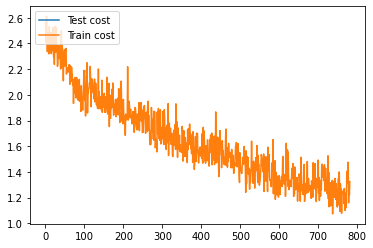

<Figure size 432x288 with 0 Axes>

In [11]:
train_loop()

In [41]:
def load_image(file):
    im = Image.open(file)
    im = im.resize((32, 32), Image.ANTIALIAS)

    im = np.array(im).astype(np.float32)
    # The storage order of the loaded image is W(width),
    # H(height), C(channel). PaddlePaddle requires
    # the CHW order, so transpose them.
    im = im.transpose((2, 0, 1))  # CHW
    im = im / 255.0

    # Add one dimension to mimic the list format.
    im = numpy.expand_dims(im, axis=0)
    return im

infer results: dog


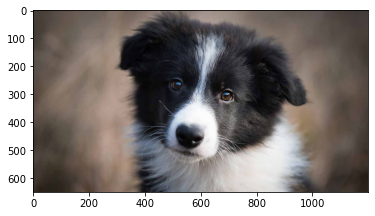

In [44]:
inference_scope = fluid.core.Scope()
label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
img_name = ('./imgs/border_collie.jpg')
target_img = load_image(img_name)

with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(
     params_dirname, exe, None, None)

    results = exe.run(inference_program,
                            feed={feed_target_names[0]: target_img},
                            fetch_list=fetch_targets)
    lab = numpy.argsort(results)

    img=Image.open(img_name)
    plt.imshow(img)
    print("infer results: %s" % label_list[np.argmax(results[0])])